In [225]:
# Diogo Meneses Franco
# RA: 2202455

In [119]:
!pip install missingno

In [120]:
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc,classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Funções que vamos usar

In [121]:
def avalia_Classificacao(model,x, y_test,pred, labels=['Positives','Negatives']):

    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]

    #FIGURE
    plt.figure(figsize=[15,4])



    #1 -- Confusion matrix
    cm_RL = confusion_matrix(y_test, pred)
    plt.subplot(131)
    ax = sns.heatmap(cm_RL, annot=True, cmap='Blues', cbar=False,
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)

    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y_test})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")

    #3 -- ROC curve with annotated decision point
    # plt.subplot(133)
    metrics.plot_roc_curve(model, x, y_test)
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm_RL.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm_RL.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    printout = (
        f'Precision: {round(precision,2)} | '
        f'Recall: {round(recall,2)} | '
        f'F1 Score: {round(F1,2)} | '
    )
    print(printout)
    return F1

# Importando a base


In [122]:
df = pd.read_csv('base_aula_futebol.csv', sep=';', encoding='utf-8')

## **Preparando a base**

In [123]:
df = df.rename(columns={'chutes_visitanes': 'chutes_visitantes'})

# **Analisando Duplicados**

In [124]:
df.duplicated().sum()

0

Verifiquei se há dados duplicados na base, poém não consta dado algum duplicado.

# Avaliando missing

In [125]:
df.isnull().sum()

time_casa                               0
time_visitante                          0
total_gols_casa                         0
total_gols_visitante                    0
total_gols_jogo                         0
total_escanteios_casa                   0
total_escanteios_visitante              0
total_cartoes_amarelos_casa             0
total_cartoes_vermelhos_casa            0
total_cartoes_amarelos_visitante        0
total_cartoes_vermelhos_visitante       0
chutes_casa                             0
chutes_visitantes                       0
chutes_no_gol_casa                      0
chutes_no_gol_visitante                 0
chutes_fora_do_gol_casa                 0
chutes_fora_do_gol_visitante            0
faltas_time_casa                        0
faltas_time_visitante                   0
posse_de_bola_casa                      0
posse_de_bola_visitante                 0
liga                                    0
qtd_torcedores                       3770
mes                               

In [126]:
3770/8670*100

43.48327566320646

# **Tratando valores missing**

In [127]:
df.qtd_torcedores.median()

7778.0

In [128]:
df.fillna(df.qtd_torcedores.median(), inplace=True)

Observei que a coluna qtd_torcedores tem 43% de valores missing, então tratei essa colona colocando o valor da mediana, dessa forma eliminando os valores missing.

# **Tabela com os dados missing tratados**

<Axes: >

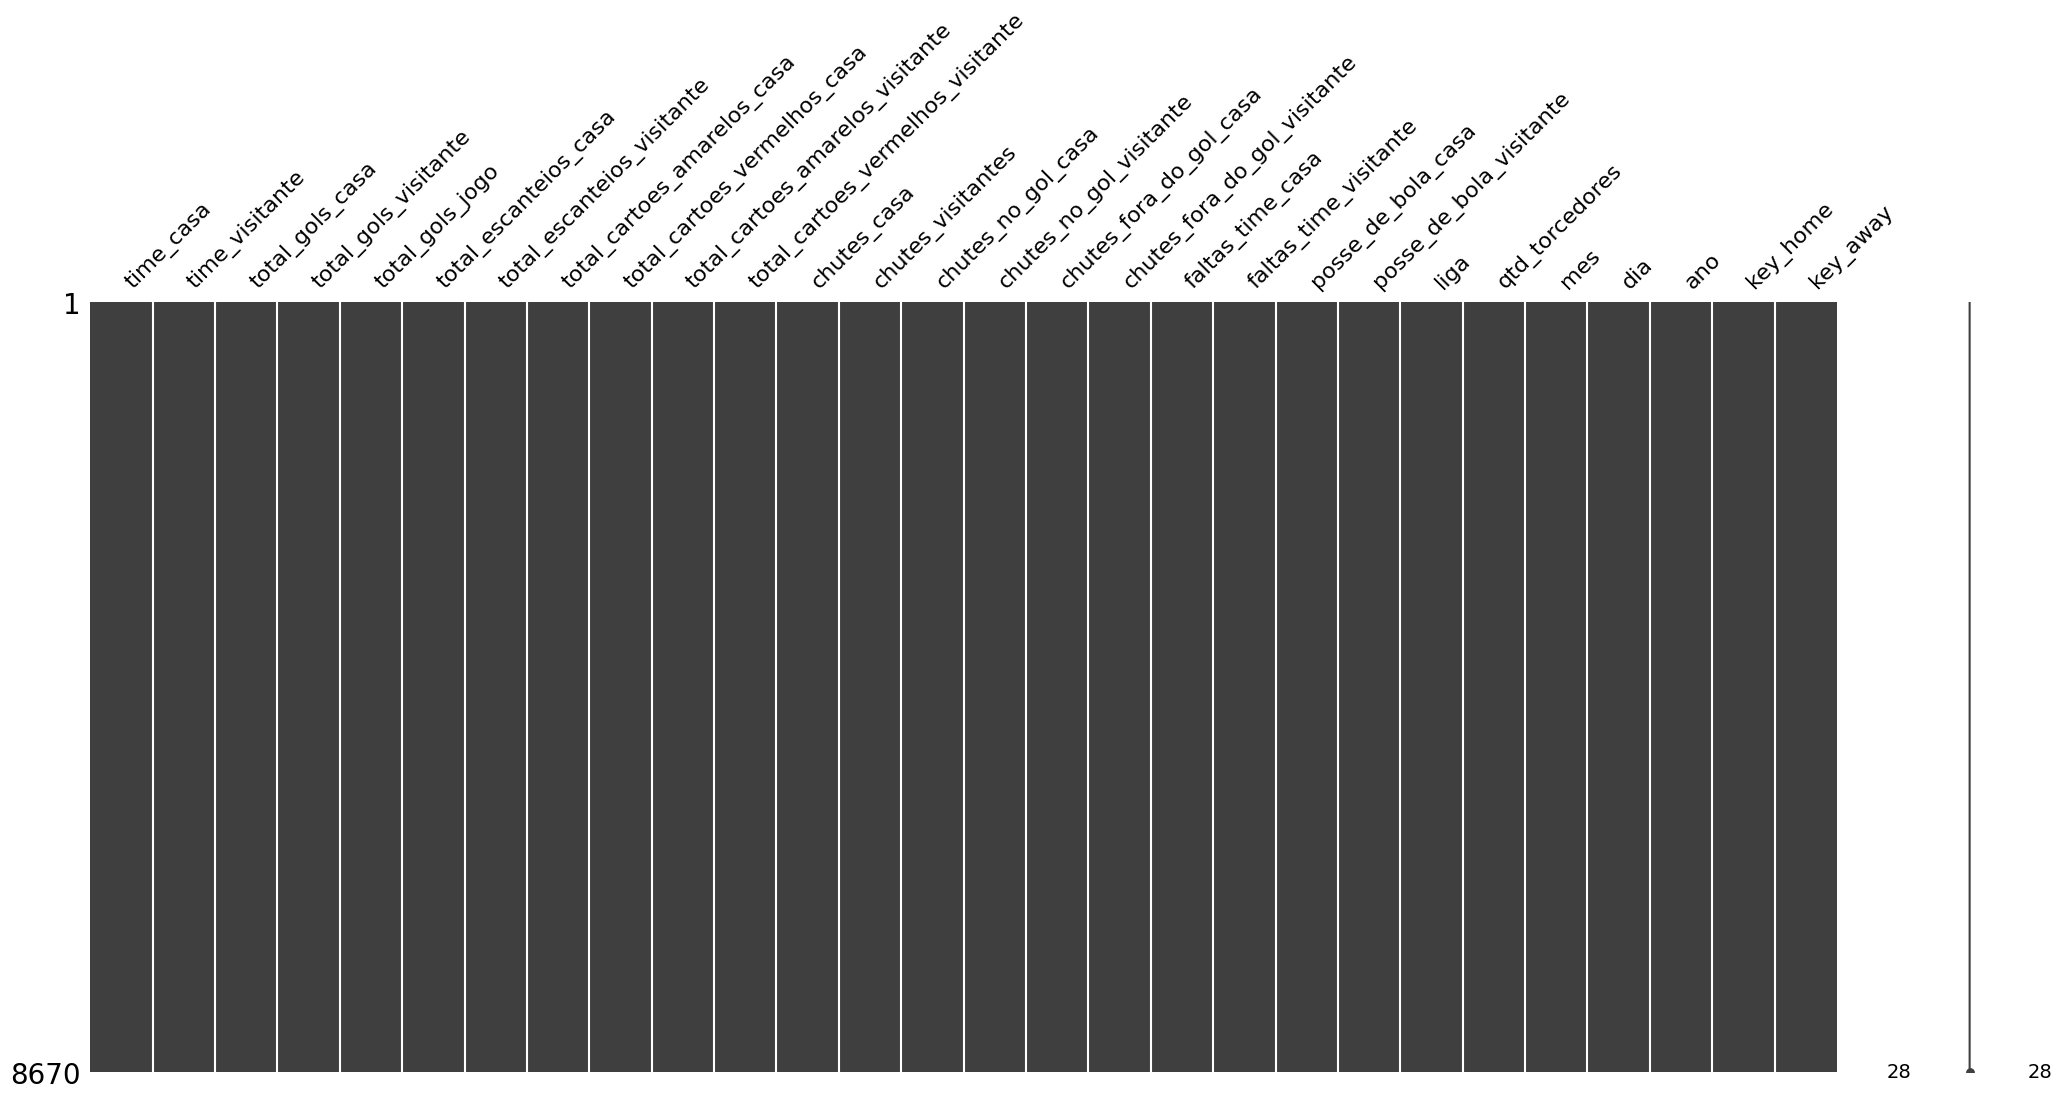

In [129]:
msno.matrix(df)

# **Tratando valores outliers**

In [130]:
df

time_casa   time_visitante  total_gols_casa  total_gols_visitante  \
0          novaiguaçu     friburguense                1                     0   
1           americarj  sampaiocorrearj                1                     1   
2           americano      cabofriense                3                     2   
3        friburguense        americano                1                     1   
4     sampaiocorrearj       novaiguaçu                1                     2   
...               ...              ...              ...                   ...   
8665        americarn      saobernardo                2                     0   
8666      saobernardo        americarn                0                     1   
8667         amazonas      pousoalegre                0                     1   
8668        americarn      pousoalegre                2                     0   
8669      pousoalegre        americarn                1                     0   

      total_gols_jogo  total_escanteios_casa  total_escanteios_visitante  \
0                   1                      6                           3   
1                   2                      3                           5   
2                   5                      3                           6   
3                   2                      7                           3   
4                   3                      7                           0   
...               ...                    ...                         ...   
8665                2                      7                           6   
8666                1                     15                           8   
8667                1                      9                           3   
8668                2                      4                           4   
8669                1                      4                           4   

      total_cartoes_amarelos_casa  total_cartoes_vermelhos_casa  \
0                              -1                            -1   
1                              -1                            -1   
2                              -1                            -1   
3                              -1                            -1   
4                              -1                            -1   
...                           ...                           ...   
8665                           -1                            -1   
8666                           -1                            -1   
8667                           -1                            -1   
8668                           -1                            -1   
8669                           -1                            -1   

      total_cartoes_amarelos_visitante  ...  faltas_time_visitante  \
0                                   -1  ...                     -1   
1                                   -1  ...                     -1   
2                                   -1  ...                     -1   
3                                   -1  ...                     -1   
4                                   -1  ...                     -1   
...                                ...  ...                    ...   
8665                                -1  ...                     -1   
8666                                -1  ...                     -1   
8667                                -1  ...                     -1   
8668                                -1  ...                     -1   
8669                                -1  ...                     -1   

      posse_de_bola_casa  posse_de_bola_visitante           liga  \
0                     49                       51  brazilcarioca   
1                     45                       55  brazilcarioca   
2                     50                       50  brazilcarioca   
3                     62                       38  brazilcarioca   
4                     62                       38  brazilcarioca   
...                  ...                      ...            ...   
8665

In [131]:
for variavel in  ['total_gols_jogo','total_gols_casa', 'total_gols_visitante','posse_de_bola_casa', 'posse_de_bola_visitante','chutes_casa', 'chutes_visitantes', 'chutes_no_gol_casa', 'chutes_no_gol_visitante','total_escanteios_casa', 'total_escanteios_visitante', 'total_cartoes_amarelos_casa', 'total_cartoes_vermelhos_casa', 'total_cartoes_amarelos_visitante', 'total_cartoes_vermelhos_visitante','faltas_time_casa', 'faltas_time_visitante', 'posse_de_bola_casa', 'posse_de_bola_visitante', 'faltas_time_visitante', 'posse_de_bola_casa', 'posse_de_bola_visitante', 'qtd_torcedores']:
 fig = px.box(df[''+variavel+''])
 fig.show()

In [132]:
df.loc[df.total_escanteios_casa == -1, 'total_escanteios_casa'] = df.total_escanteios_casa.median()
df.loc[df.total_escanteios_visitante == -1, 'total_escanteios_visitante'] = df.total_escanteios_casa.median()
df.loc[df.total_cartoes_amarelos_casa == -1, 'total_cartoes_amarelos_casa'] = df.total_cartoes_amarelos_casa.median()
df.loc[df.total_cartoes_vermelhos_casa == -1, 'total_cartoes_vermelhos_casa'] = df.total_cartoes_vermelhos_casa.median()
df.loc[df.total_cartoes_amarelos_visitante == -1, 'total_cartoes_amarelos_visitante'] = df.total_cartoes_amarelos_visitante.median()
df.loc[df.total_cartoes_vermelhos_visitante == -1, 'total_cartoes_vermelhos_visitante'] = df.total_cartoes_vermelhos_visitante.median()
df.loc[df.chutes_casa == -1, 'chutes_casa'] = df.total_gols_casa
df.loc[df.chutes_visitantes == -1, 'chutes_visitantes'] = df.total_gols_visitante
df.loc[df.chutes_no_gol_casa == -1, 'chutes_no_gol_casa'] = df.total_gols_casa
df.loc[df.chutes_no_gol_visitante == -1, 'chutes_no_gol_visitante'] = df.total_gols_visitante
df.loc[df.chutes_fora_do_gol_casa == -1, 'chutes_fora_do_gol_casa'] = 0
df.loc[df.chutes_fora_do_gol_visitante == -1, 'chutes_fora_do_gol_visitante'] = 0
df.loc[df.faltas_time_casa == -1, 'faltas_time_casa'] = df.faltas_time_casa.median()
df.loc[df.faltas_time_visitante == -1, 'faltas_time_visitante'] = df.faltas_time_visitante.median()
df.loc[df.posse_de_bola_casa == -1, 'posse_de_bola_casa'] = df.posse_de_bola_casa.median()
df.loc[df.posse_de_bola_visitante == -1, 'posse_de_bola_visitante'] = 100 - df.posse_de_bola_casa
df.loc[df.qtd_torcedores == -1, 'qtd_torcedores'] = df.qtd_torcedores.median()

Analisei todas as colunas que poderiam ter outliers, e encontrei os seguintes dados:

**Colunas:**

**total_escanteios_casa:** substitui o valor -1 pela mediana dessa coluna.

**total_escanteios_visitante:** substitui o valor -1 pela mediana dessa coluna.

**total_cartoes_amarelos_casa:** substitui o valor -1 pela mediana dessa coluna.

**total_cartoes_vermelhos_casa:** substitui o valor -1 pela mediana dessa coluna.

**total_cartoes_amarelos_visitante:** substitui o valor -1 pela mediana dessa coluna.

**total_cartoes_vermelhos_visitante:** substitui o valor -1 pela mediana dessa coluna.

**chutes_casa:** substitui o valor -1 pelo total de gols casa.

**chutes_visitantes:** substitui o valor -1 pelo total de gols visitante.

**chutes_no_gol_casa:** substitui o valor -1 pelo total de gols casa.

**chutes_no_gol_visitante:** substitui o valor -1 pelo total de gols visitante.

**chutes_fora_do_gol_casa:** substitui o valor -1 por 0.

**chutes_fora_do_gol_visitante:** substitui o valor -1 por 0 coluna.

**faltas_time_casa:** substitui o valor -1 pela mediana dessa coluna.

**faltas_time_visitante:** substitui o valor -1 pela mediana dessa coluna.

**posse_de_bola_casa:** substitui o valor -1 pela mediana dessa coluna.

**posse_de_bola_visitante:** substitui o valor -1 por 100 - posso de bola casa.

# **Medidas de posição e dispersão das variaveis**

In [133]:
df.total_gols_jogo.describe()

count    8670.000000
mean        2.322030
std         1.530438
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        12.000000
Name: total_gols_jogo, dtype: float64

A média total de gols nos jogos é de 2.3; quando desvia, desvia em torno de 1.5 em relação a média; e 50% dos dados vão até 2 gols nos jogos.

In [134]:
df.total_gols_casa.describe()

count    8670.000000
mean        1.372664
std         1.153514
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: total_gols_casa, dtype: float64

A média total de gols do time da casa é de 1.3; quando desvia, desvia em torno de 1.1 em relação a média; e 50% dos dados vão até 1 gol para o time da casa.

In [135]:
df.total_gols_visitante.describe()

count    8670.000000
mean        0.949366
std         0.980298
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         7.000000
Name: total_gols_visitante, dtype: float64

A média total de gols do time visitante é de 0.9; quando desvia, desvia em torno de 0.98 em relação a média; e 50% dos dados vão até 1 gol para o time visitante.

In [136]:
df.total_escanteios_casa.describe()

count    8670.000000
mean        5.898155
std         3.077255
min         0.000000
25%         4.000000
50%         5.000000
75%         8.000000
max        22.000000
Name: total_escanteios_casa, dtype: float64

A média total de escanteios do time da casa é de 5.8; quando desvia, desvia em torno de 3 em relação a média; e 50% dos dados vão até 5 escanteios para o time da casa.

In [137]:
df.total_escanteios_visitante.describe()

count    8670.000000
mean        4.538639
std         2.599115
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        19.000000
Name: total_escanteios_visitante, dtype: float64

A média total de escanteios do time visitante é de 4.5; quando desvia, desvia em torno de 2.6 em relação a média; e 50% dos dados vão até 4 escanteios para o time visitante.

In [138]:
df.total_cartoes_amarelos_casa.describe()

count    8670.000000
mean        2.186505
std         1.345471
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        10.000000
Name: total_cartoes_amarelos_casa, dtype: float64

A média total de cartões amarelos do time da casa é de 2; quando desvia, desvia em torno de 1.3 em relação a média; e 50% dos dados vão até 2 cartões para o time da casa.

In [139]:
df.total_cartoes_amarelos_visitante.describe()

count    8670.000000
mean        2.494118
std         1.434187
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         9.000000
Name: total_cartoes_amarelos_visitante, dtype: float64

A média total de cartões amarelos do time visitante é de 2.2; quando desvia, desvia em torno de 1.7 em relação a média; e 50% dos dados vão até 2 cartões para o time visitante.

In [140]:
df.total_cartoes_vermelhos_casa.describe()

count    8670.000000
mean        0.098270
std         0.320463
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: total_cartoes_vermelhos_casa, dtype: float64

A média total de cartões vermelhos do time da casa é de 0.09; quando desvia, desvia em torno de 0.3 em relação a média; e 50% dos dados vão até 0 cartões para o time da casa.

In [141]:
df.total_cartoes_vermelhos_visitante.describe()

count    8670.000000
mean        0.139446
std         0.385815
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: total_cartoes_vermelhos_visitante, dtype: float64

A média total de cartões vermelhos do time visitante de 0.13; quando desvia, desvia em torno de 0.38 em relação a média; e 50% dos dados vão até 0 cartões para o time visitante.

In [142]:
df.chutes_casa.describe()

count    8670.000000
mean       12.452710
std         5.284043
min         0.000000
25%         9.000000
50%        12.000000
75%        16.000000
max        37.000000
Name: chutes_casa, dtype: float64

A média total de chutes da casa é de 12; quando desvia, desvia em torno de 5 em relação a média; e 50% dos dados vão até 12 chutes para o time da casa.

In [143]:
df.chutes_visitantes.describe()

count    8670.000000
mean        9.788120
std         4.542462
min         0.000000
25%         7.000000
50%         9.000000
75%        12.000000
max       102.000000
Name: chutes_visitantes, dtype: float64

A média total de chutes do visitante é de 9; quando desvia, desvia em torno de 4 em relação a média; e 50% dos dados vão até 9 chutes para o time visitante.

In [144]:
df.chutes_no_gol_casa.describe()

count    8670.000000
mean        5.233449
std         2.517203
min         0.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        18.000000
Name: chutes_no_gol_casa, dtype: float64

A média total de chutes no gol da casa é de 5; quando desvia, desvia em torno de 2 em relação a média; e 50% dos dados vão até 5 chutes para o time da casa.


In [145]:
df.chutes_no_gol_visitante.describe()

count    8670.000000
mean        4.141061
std         2.192345
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        16.000000
Name: chutes_no_gol_visitante, dtype: float64

A média total de chutes no gol do visitante é de 4; quando desvia, desvia em torno de 2 em relação a média; e 50% dos dados vão até 4 chutes para o time visitante.

In [146]:
df.chutes_fora_do_gol_casa.describe()

count    8670.000000
mean        7.219723
std         3.971237
min         0.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        28.000000
Name: chutes_fora_do_gol_casa, dtype: float64

A média total de chutes para fora do time da casa é de 7; quando desvia, desvia em torno de 3.9 em relação a média; e 50% dos dados vão até 7 chutes para fora do time da casa.


In [147]:
df.chutes_fora_do_gol_visitante.describe()

count    8670.000000
mean        5.647520
std         3.483475
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        96.000000
Name: chutes_fora_do_gol_visitante, dtype: float64

A média total de chutes para fora do time visitante é de 5; quando desvia, desvia em torno de 3.4 em relação a média; e 50% dos dados vão até 5 chutes para fora do time visitante.


In [148]:
df.faltas_time_casa.describe()

count    8670.000000
mean       15.432295
std         4.528040
min         0.000000
25%        13.000000
50%        14.000000
75%        18.000000
max        37.000000
Name: faltas_time_casa, dtype: float64

A média total de faltas do time da casa é de 15; quando desvia, desvia em torno de 4.5 em relação a média; e 50% dos dados vão até 14 chutes para fora do time da casa.


In [149]:
df.faltas_time_visitante.describe()

count    8670.000000
mean       15.476471
std         4.612705
min         0.000000
25%        13.000000
50%        14.000000
75%        18.000000
max        37.000000
Name: faltas_time_visitante, dtype: float64

A média total de faltas do time visitante é de 15; quando desvia, desvia em torno de 4.6 em relação a média; e 50% dos dados vão até 14 chutes para fora do time visitante.


In [150]:
df.posse_de_bola_casa.describe()

count    8670.000000
mean       51.837140
std         8.253147
min        12.000000
25%        47.000000
50%        51.000000
75%        57.000000
max       100.000000
Name: posse_de_bola_casa, dtype: float64

A média total de posse de bola do time da casa é de 51%; quando desvia, desvia em torno de 8% em relação a média; e 50% dos dados vão até 51% de posse de bola para o time da casa.


In [151]:
df.posse_de_bola_visitante.describe()

count    8670.000000
mean       48.162860
std         8.253147
min         0.000000
25%        43.000000
50%        49.000000
75%        53.000000
max        88.000000
Name: posse_de_bola_visitante, dtype: float64

A média total de posse de bola do visitante de 48%; quando desvia, desvia em torno de 8% em relação a média; e 50% dos dados vão até 49% de posse de bola para o time visitante.


In [152]:
df.qtd_torcedores.describe()

count     8670.000000
mean      9950.302768
std       9268.965531
min          0.000000
25%       6435.750000
50%       7778.000000
75%       9127.750000
max      69980.000000
Name: qtd_torcedores, dtype: float64

A média de torcedores nos jogos é de 9950; quando desvia, desvia em torno de 9.268; e 50% dos dados vão até 7.778 torcedores.

In [153]:
df.ano.describe()

count    8670.000000
mean     2017.824221
std         3.053567
min      2013.000000
25%      2015.000000
50%      2018.000000
75%      2021.000000
max      2022.000000
Name: ano, dtype: float64

A média de ano dos jogos é de 2017; quando desvia, desvia em torno de 3 anos; e 50% dos dados vão até 2018.

In [154]:
df.describe()

total_gols_casa  total_gols_visitante  total_gols_jogo  \
count      8670.000000           8670.000000      8670.000000   
mean          1.372664              0.949366         2.322030   
std           1.153514              0.980298         1.530438   
min           0.000000              0.000000         0.000000   
25%           1.000000              0.000000         1.000000   
50%           1.000000              1.000000         2.000000   
75%           2.000000              1.000000         3.000000   
max          10.000000              7.000000        12.000000   

       total_escanteios_casa  total_escanteios_visitante  \
count            8670.000000                 8670.000000   
mean                5.898155                    4.538639   
std                 3.077255                    2.599115   
min                 0.000000                    0.000000   
25%                 4.000000                    3.000000   
50%                 5.000000                    4.000000   
75%                 8.000000                    6.000000   
max                22.000000                   19.000000   

       total_cartoes_amarelos_casa  total_cartoes_vermelhos_casa  \
count                  8670.000000                   8670.000000   
mean                      2.186505                      0.098270   
std                       1.345471                      0.320463   
min                       0.000000                      0.000000   
25%                       1.000000                      0.000000   
50%                       2.000000                      0.000000   
75%                       3.000000                      0.000000   
max                      10.000000                      3.000000   

       total_cartoes_amarelos_visitante  total_cartoes_vermelhos_visitante  \
count                       8670.000000                        8670.000000   
mean                           2.494118                           0.139446   
std                            1.434187                           0.385815   
min                            0.000000                           0.000000   
25%                            2.000000                           0.000000   
50%                            2.000000                           0.000000   
75%                            3.000000                           0.000000   
max                            9.000000                           3.000000   

       chutes_casa  ...  chutes_fora_do_gol_casa  \
count  8670.000000  ...              8670.000000   
mean     12.452710  ...                 7.219723   
std       5.284043  ...                 3.971237   
min       0.000000  ...                 0.000000   
25%       9.000000  ...                 5.000000   
50%      12.000000  ...                 7.000000   
75%      16.000000  ...                10.000000   
max      37.000000  ...                28.000000   

       chutes_fora_do_gol_visitante  faltas_time_casa  faltas_time_visitante  \
count                   8670.000000       8670.000000            8670.000000   
mean                       5.647520         15.432295              15.476471   
std                        3.483475          4.528040               4.612705   
min                        0.000000          0.000000               0.000000   
25%                        3.000000         13.000000              13.000000   
50%                        5.000000         14.000000              14.000000   
75%                        7.000000         18.000000              18.000000   
max                       96.000000         37.000000              37.000000   

       posse_de_bola_casa  posse_de_bola_visitante  qtd_torcedores  \
count         8670.000000              8670.000000     8670.000000   
mean            51.837140                48.162860     9950.302768   
std              8.253147                 8.253147     9268.965531   
min             12.000000                 0.000000        0.000000   
25%             47.00000

In [155]:
for variavel in ['total_gols_jogo','total_gols_casa', 'total_gols_visitante','posse_de_bola_casa', 'posse_de_bola_visitante','chutes_casa', 'chutes_visitantes', 'chutes_no_gol_casa', 'chutes_no_gol_visitante','total_escanteios_casa', 'total_escanteios_visitante', 'total_cartoes_amarelos_casa', 'total_cartoes_vermelhos_casa', 'total_cartoes_amarelos_visitante', 'total_cartoes_vermelhos_visitante','faltas_time_casa', 'faltas_time_visitante', 'posse_de_bola_casa', 'posse_de_bola_visitante', 'faltas_time_visitante', 'posse_de_bola_casa', 'posse_de_bola_visitante', 'qtd_torcedores']:
 fig = px.histogram(df[''+variavel+''])
 fig.show()

# **Gráficos**

#**Correlações**

In [156]:
df

time_casa   time_visitante  total_gols_casa  total_gols_visitante  \
0          novaiguaçu     friburguense                1                     0   
1           americarj  sampaiocorrearj                1                     1   
2           americano      cabofriense                3                     2   
3        friburguense        americano                1                     1   
4     sampaiocorrearj       novaiguaçu                1                     2   
...               ...              ...              ...                   ...   
8665        americarn      saobernardo                2                     0   
8666      saobernardo        americarn                0                     1   
8667         amazonas      pousoalegre                0                     1   
8668        americarn      pousoalegre                2                     0   
8669      pousoalegre        americarn                1                     0   

      total_gols_jogo  total_escanteios_casa  total_escanteios_visitante  \
0                   1                      6                           3   
1                   2                      3                           5   
2                   5                      3                           6   
3                   2                      7                           3   
4                   3                      7                           0   
...               ...                    ...                         ...   
8665                2                      7                           6   
8666                1                     15                           8   
8667                1                      9                           3   
8668                2                      4                           4   
8669                1                      4                           4   

      total_cartoes_amarelos_casa  total_cartoes_vermelhos_casa  \
0                               2                             0   
1                               2                             0   
2                               2                             0   
3                               2                             0   
4                               2                             0   
...                           ...                           ...   
8665                            2                             0   
8666                            2                             0   
8667                            2                             0   
8668                            2                             0   
8669                            2                             0   

      total_cartoes_amarelos_visitante  ...  faltas_time_visitante  \
0                                    2  ...                     14   
1                                    2  ...                     14   
2                                    2  ...                     14   
3                                    2  ...                     14   
4                                    2  ...                     14   
...                                ...  ...                    ...   
8665                                 2  ...                     14   
8666                                 2  ...                     14   
8667                                 2  ...                     14   
8668                                 2  ...                     14   
8669                                 2  ...                     14   

      posse_de_bola_casa  posse_de_bola_visitante           liga  \
0                     49                       51  brazilcarioca   
1                     45                       55  brazilcarioca   
2                     50                       50  brazilcarioca   
3                     62                       38  brazilcarioca   
4                     62                       38  brazilcarioca   
...                  ...                      ...            ...   
8665

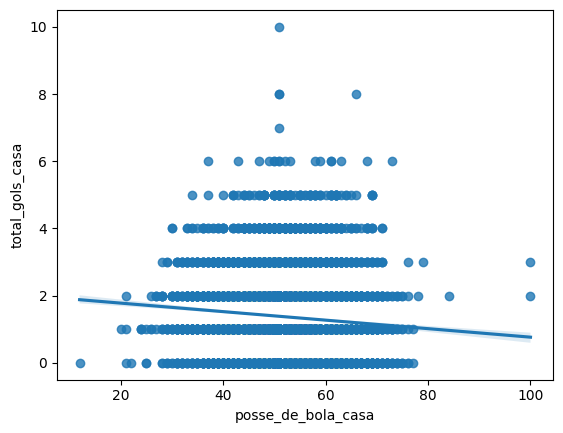

In [157]:
graf_reg = sns.regplot(data = df, x = 'posse_de_bola_casa', y = 'total_gols_casa')

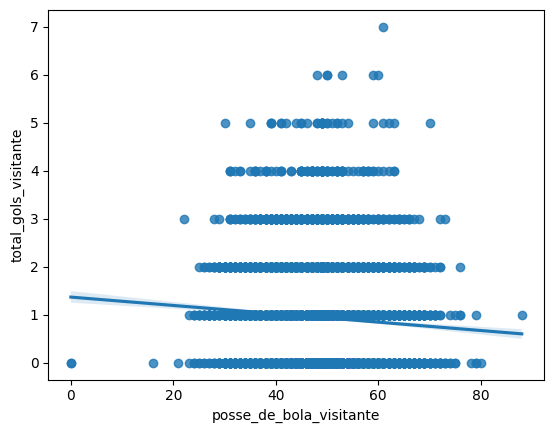

In [158]:
graf_reg = sns.regplot(data = df, x = 'posse_de_bola_visitante', y = 'total_gols_visitante')

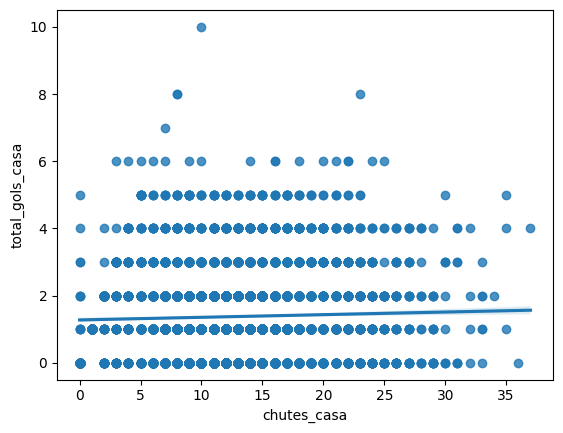

In [159]:
graf_reg = sns.regplot(data = df, x = 'chutes_casa', y = 'total_gols_casa')

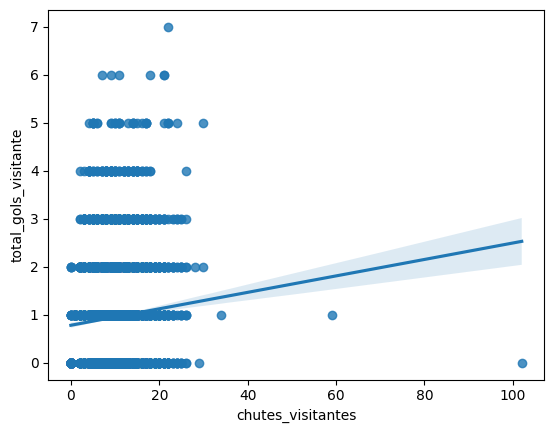

In [160]:
graf_reg = sns.regplot(data = df, x = 'chutes_visitantes', y = 'total_gols_visitante')

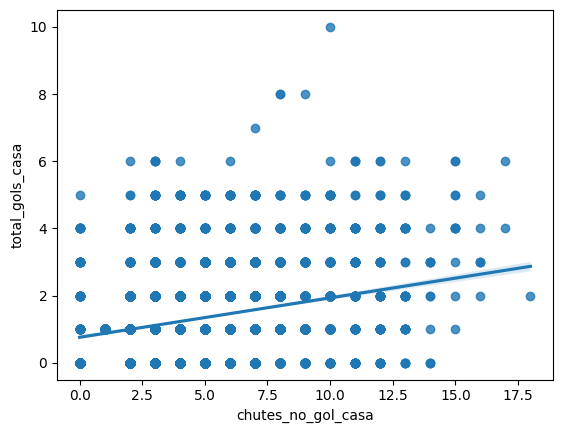

In [161]:
graf_reg = sns.regplot(data = df, x = 'chutes_no_gol_casa', y = 'total_gols_casa')

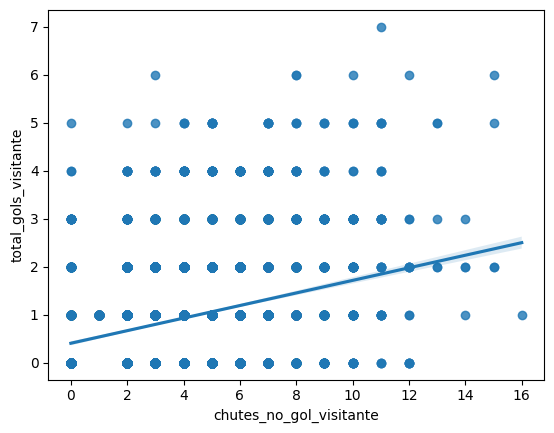

In [162]:
graf_reg = sns.regplot(data = df, x = 'chutes_no_gol_visitante', y = 'total_gols_visitante')

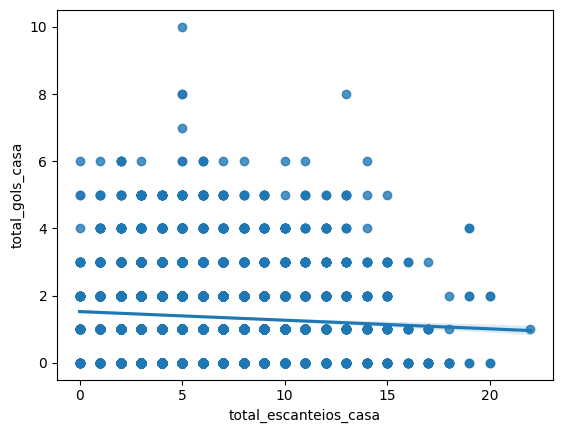

In [163]:
graf_reg = sns.regplot(data = df, x = 'total_escanteios_casa', y = 'total_gols_casa')

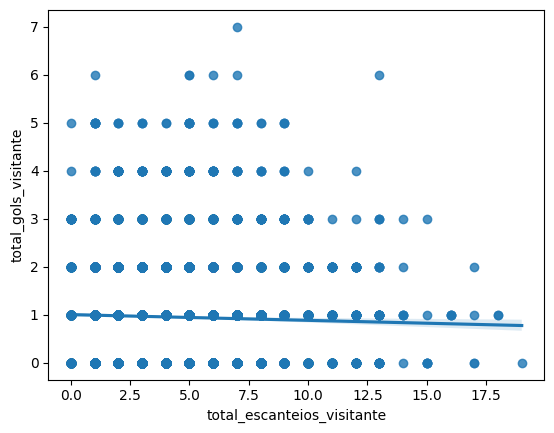

In [164]:
graf_reg = sns.regplot(data = df, x = 'total_escanteios_visitante', y = 'total_gols_visitante')

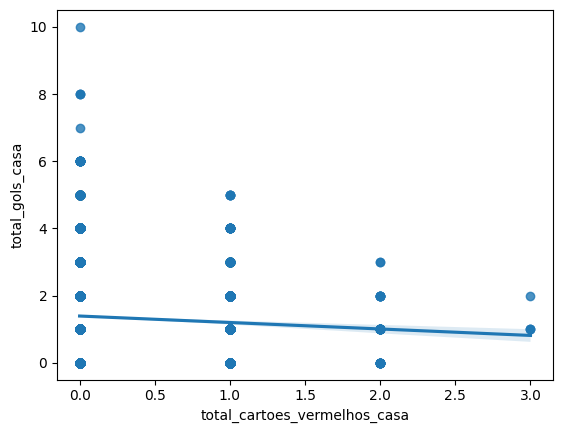

In [165]:
graf_reg = sns.regplot(data = df, x = 'total_cartoes_vermelhos_casa', y = 'total_gols_casa')

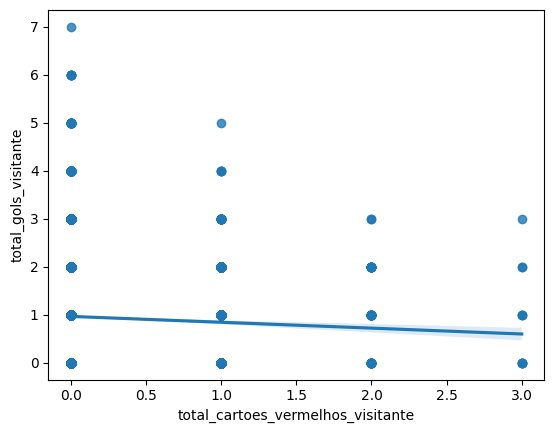

In [166]:
graf_reg = sns.regplot(data = df, x = 'total_cartoes_vermelhos_visitante', y = 'total_gols_visitante')

Nos gráficos acima, resolvi criar uma visualização de dispersão para avaliar as correlações entre as variáveis, já pensando nos testes de modelos que logo mais irei criar para gerar os três modelos de classificação.

Analisando as variáveis, criando as correlações, obtive uma resposta "positiva" de quatro correlações, sendo quanto maior o valor da variável X, maior é o valor da variável Y, são elas:

x = chutes_casa, y = total_gols_casa;

x = chutes_visitanes, = y = total_gols_visitante;

x = chutes_no_gol_casa, y = total_gols_casa;

x = chutes_no_gol_visitante, y = total_gols_visitante.




# **Feature Engeneering**

In [167]:
df

time_casa   time_visitante  total_gols_casa  total_gols_visitante  \
0          novaiguaçu     friburguense                1                     0   
1           americarj  sampaiocorrearj                1                     1   
2           americano      cabofriense                3                     2   
3        friburguense        americano                1                     1   
4     sampaiocorrearj       novaiguaçu                1                     2   
...               ...              ...              ...                   ...   
8665        americarn      saobernardo                2                     0   
8666      saobernardo        americarn                0                     1   
8667         amazonas      pousoalegre                0                     1   
8668        americarn      pousoalegre                2                     0   
8669      pousoalegre        americarn                1                     0   

      total_gols_jogo  total_escanteios_casa  total_escanteios_visitante  \
0                   1                      6                           3   
1                   2                      3                           5   
2                   5                      3                           6   
3                   2                      7                           3   
4                   3                      7                           0   
...               ...                    ...                         ...   
8665                2                      7                           6   
8666                1                     15                           8   
8667                1                      9                           3   
8668                2                      4                           4   
8669                1                      4                           4   

      total_cartoes_amarelos_casa  total_cartoes_vermelhos_casa  \
0                               2                             0   
1                               2                             0   
2                               2                             0   
3                               2                             0   
4                               2                             0   
...                           ...                           ...   
8665                            2                             0   
8666                            2                             0   
8667                            2                             0   
8668                            2                             0   
8669                            2                             0   

      total_cartoes_amarelos_visitante  ...  faltas_time_visitante  \
0                                    2  ...                     14   
1                                    2  ...                     14   
2                                    2  ...                     14   
3                                    2  ...                     14   
4                                    2  ...                     14   
...                                ...  ...                    ...   
8665                                 2  ...                     14   
8666                                 2  ...                     14   
8667                                 2  ...                     14   
8668                                 2  ...                     14   
8669                                 2  ...                     14   

      posse_de_bola_casa  posse_de_bola_visitante           liga  \
0                     49                       51  brazilcarioca   
1                     45                       55  brazilcarioca   
2                     50                       50  brazilcarioca   
3                     62                       38  brazilcarioca   
4                     62                       38  brazilcarioca   
...                  ...                      ...            ...   
8665

In [168]:
df.shape

(8670, 28)

In [169]:
df.columns

Index(['time_casa', 'time_visitante', 'total_gols_casa',
       'total_gols_visitante', 'total_gols_jogo', 'total_escanteios_casa',
       'total_escanteios_visitante', 'total_cartoes_amarelos_casa',
       'total_cartoes_vermelhos_casa', 'total_cartoes_amarelos_visitante',
       'total_cartoes_vermelhos_visitante', 'chutes_casa', 'chutes_visitantes',
       'chutes_no_gol_casa', 'chutes_no_gol_visitante',
       'chutes_fora_do_gol_casa', 'chutes_fora_do_gol_visitante',
       'faltas_time_casa', 'faltas_time_visitante', 'posse_de_bola_casa',
       'posse_de_bola_visitante', 'liga', 'qtd_torcedores', 'mes', 'dia',
       'ano', 'key_home', 'key_away'],
      dtype='object')

# **Análise da variável Liga, chutes_no_gol_casa, chutes_no_gol_visitante**

In [170]:
df.liga

0       brazilcarioca
1       brazilcarioca
2       brazilcarioca
3       brazilcarioca
4       brazilcarioca
            ...      
8665       brazilcopa
8666      brazilserie
8667      brazilserie
8668       brazilcopa
8669       brazilcopa
Name: liga, Length: 8670, dtype: object

In [171]:
df.liga.value_counts()

brazilcopa               2784
brazilserie              2350
southamerica             1934
brazilcarioca             487
brazilpaulista            362
brazilgaucho              327
brazilmineiro             294
europeuefa                123
internationalconcacaf       9
Name: liga, dtype: int64

In [172]:
df.chutes_no_gol_casa

0       5
1       4
2       8
3       3
4       8
       ..
8665    4
8666    4
8667    7
8668    8
8669    7
Name: chutes_no_gol_casa, Length: 8670, dtype: int64

In [173]:
df.chutes_no_gol_casa.value_counts()

5     1473
4     1436
6     1188
3     1145
7      928
2      660
8      623
9      362
10     245
0      242
11     125
1      112
12      62
13      37
15      12
14      11
16       6
17       2
18       1
Name: chutes_no_gol_casa, dtype: int64

In [174]:
df.chutes_no_gol_visitante

0        4
1        3
2       11
3        4
4        8
        ..
8665     4
8666     3
8667     5
8668     2
8669     3
Name: chutes_no_gol_visitante, Length: 8670, dtype: int64

In [175]:
df.chutes_no_gol_visitante.value_counts()

3     1680
4     1606
5     1386
2     1266
6      959
7      542
0      537
8      300
9      157
1       97
10      79
11      32
12      15
13       5
15       4
14       4
16       1
Name: chutes_no_gol_visitante, dtype: int64

In [176]:
df_liga = df.groupby(['liga'])['total_gols_jogo'].agg(['mean', 'count']).sort_values(by=['mean'], ascending=False).reset_index().rename(columns={'mean':'media_gols_jogo', 'count':'total_jogos_liga'})
df = pd.merge(df, df_liga, on='liga', how='left')

df_chute_casa = df.groupby(['chutes_no_gol_casa'])['total_gols_casa'].agg(['mean', 'count']).sort_values(by=['mean'], ascending=False).reset_index().rename(columns={'mean':'media_gols_casa', 'count':'chutes_gol_casa_partida'})
df = pd.merge(df, df_chute_casa, on='chutes_no_gol_casa', how='left')

df_chute_visitante = df.groupby(['chutes_no_gol_visitante'])['total_gols_visitante'].agg(['mean', 'count']).sort_values(by=['mean'], ascending=False).reset_index().rename(columns={'mean':'media_gols_visitante', 'count':'chutes_gol_visitante_partida'})
df = pd.merge(df, df_chute_visitante, on='chutes_no_gol_visitante', how='left')




In [177]:
df_liga

liga  media_gols_jogo  total_jogos_liga
0          brazilmineiro         2.469388               294
1         brazilpaulista         2.425414               362
2           southamerica         2.416753              1934
3             europeuefa         2.341463               123
4             brazilcopa         2.330460              2784
5          brazilcarioca         2.305955               487
6           brazilgaucho         2.266055               327
7            brazilserie         2.212340              2350
8  internationalconcacaf         1.666667                 9

In [178]:
df_chute_casa

chutes_no_gol_casa  media_gols_casa  chutes_gol_casa_partida
0                   17         5.000000                        2
1                   15         4.000000                       12
2                   16         3.333333                        6
3                   13         2.459459                       37
4                   12         2.096774                       62
5                   10         2.008163                      245
6                   11         2.008000                      125
7                   18         2.000000                        1
8                   14         1.909091                       11
9                    9         1.723757                      362
10                   8         1.683788                      623
11                   7         1.578664                      928
12                   6         1.425084                     1188
13                   5         1.335370                     1473
14                   4         1.229805                     1436
15                   3         1.143231                     1145
16                   2         1.063636                      660
17                   1         1.000000                      112
18                   0         0.615702                      242

In [179]:
df_chute_visitante

chutes_no_gol_visitante  media_gols_visitante  \
0                        15              3.750000   
1                        13              3.400000   
2                        11              2.531250   
3                        14              2.000000   
4                        10              1.924051   
5                        12              1.600000   
6                         9              1.547771   
7                         8              1.396667   
8                         7              1.319188   
9                         6              1.136601   
10                        5              1.070707   
11                       16              1.000000   
12                        1              1.000000   
13                        4              0.948941   
14                        3              0.760714   
15                        2              0.686414   
16                        0              0.398510   

    chutes_gol_visitante_partida  
0                              4  
1                              5  
2                             32  
3                              4  
4                             79  
5                             15  
6                            157  
7                            300  
8                            542  
9                            959  
10                          1386  
11                             1  
12                            97  
13                          1606  
14                          1680  
15                          1266  
16                           537

In [180]:
df.shape

(8670, 34)

Nesse processo de Feature Engeneering, analisando os dados que eu tinha na base, e pensando nos modelos de classificação que irei criar, criei seis colunas na base, sendo elas:

**media_gols_jogo**: essa variável trás para análise mais profunda, a média de gols por jogo de cada liga.

**total_jogos_liga**: essa variável representa o total de jogos que cada liga obteve.

**media_gols_casa**: essa variável trás para análise mais profunda, a média de gols do time da casa.

**chutes_gol_casa_partida**: essa variável representa o número de chutes no gol do time da casa para cada partida.

**media_gols_visitante** essa variável trás para análise mais profunda, a média de gols do time visitante

**chutes_gol_visitante_partida**: essa variável representa o número de chutes no gol do time visitante para cada partida.

# **Dummificação**

# Criando a variável resposta da classificação

In [181]:
df

time_casa   time_visitante  total_gols_casa  total_gols_visitante  \
0          novaiguaçu     friburguense                1                     0   
1           americarj  sampaiocorrearj                1                     1   
2           americano      cabofriense                3                     2   
3        friburguense        americano                1                     1   
4     sampaiocorrearj       novaiguaçu                1                     2   
...               ...              ...              ...                   ...   
8665        americarn      saobernardo                2                     0   
8666      saobernardo        americarn                0                     1   
8667         amazonas      pousoalegre                0                     1   
8668        americarn      pousoalegre                2                     0   
8669      pousoalegre        americarn                1                     0   

      total_gols_jogo  total_escanteios_casa  total_escanteios_visitante  \
0                   1                      6                           3   
1                   2                      3                           5   
2                   5                      3                           6   
3                   2                      7                           3   
4                   3                      7                           0   
...               ...                    ...                         ...   
8665                2                      7                           6   
8666                1                     15                           8   
8667                1                      9                           3   
8668                2                      4                           4   
8669                1                      4                           4   

      total_cartoes_amarelos_casa  total_cartoes_vermelhos_casa  \
0                               2                             0   
1                               2                             0   
2                               2                             0   
3                               2                             0   
4                               2                             0   
...                           ...                           ...   
8665                            2                             0   
8666                            2                             0   
8667                            2                             0   
8668                            2                             0   
8669                            2                             0   

      total_cartoes_amarelos_visitante  ...  dia   ano             key_home  \
0                                    2  ...   16  2021       novaiguaçu_bra   
1                                    2  ...   16  2021        americarj_bra   
2                                    2  ...   16  2021        americano_bra   
3                                    2  ...   20  2021     friburguense_bra   
4                                    2  ...   20  2021  sampaiocorrearj_bra   
...                                ...  ...  ...   ...                  ...   
8665                                 2  ...    4  2022        americarn_bra   
8666                                 2  ...   10  2022      saobernardo_bra   
8667                                 2  ...   11  2022         amazonas_bra   
8668                                 2  ...   18  2022        americarn_bra   
8669                                 2  ...   25  2022      pousoalegre_bra   

                 key_away  media_gols_jogo  total_jogos_liga  media_gols_casa  \
0        friburguense_bra         2.305955               487         1.335370   
1     sampaiocorrearj_bra         2.305955               487         1.229805   
2         cabofriense_bra         2.305955               487         1.683788   
3           americano_bra         2.305955      

In [182]:
df['mdg']=(df.total_gols_jogo>2)*1

In [183]:
df.mdg

0       0
1       0
2       1
3       0
4       1
       ..
8665    0
8666    0
8667    0
8668    0
8669    0
Name: mdg, Length: 8670, dtype: int64

In [184]:
gols = df.mdg.value_counts()
gols

0    5077
1    3593
Name: mdg, dtype: int64

<Axes: >

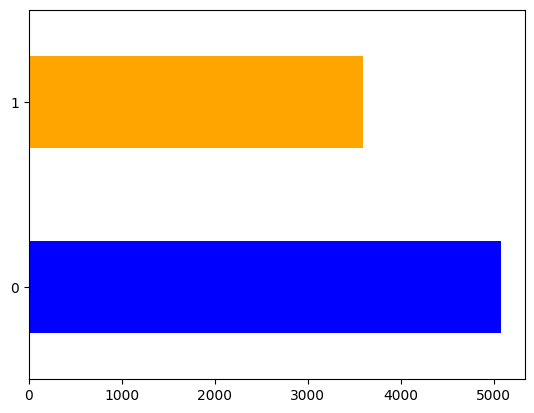

In [185]:
gols.plot(kind='barh', color = ['blue','orange'])

Foi criado a variável mdg  que tem valor de 0 ou 1.

A lógica dessa variável é que em cima da variável total_gols_jogo, que significa o total de gols que teve na partida, e a partir desse número tem uma condição que, se o número total de gols na partida for maior que dois, a variável mdg recebe um valor de 1, se for menor que dois, a variável mdg recebe 0.

1 = mais que dois gols na partida;

0 = menos que dois gols na partida;

Com isso, pude observar que 3.593 jogos teve mais de dois gols na partida, já 5.077 tiveram menos que dois gols na partida.

Essa variável mdg, irá servir como a variável de resposta da classificação.

# Separando a base em treino e teste

In [186]:
from sklearn.model_selection import train_test_split

## Selecionando as variáveis de entrada do modelo

Serão todas, exceto as que estão no drop abaixo

In [187]:
X = df.drop(columns=['time_casa', 'time_visitante', 'total_gols_casa','liga',
       'total_gols_visitante', 'total_gols_jogo',
       'qtd_torcedores', 'mes', 'dia',
       'ano', 'key_home', 'key_away', 'mdg'])

y = df.mdg

In [188]:
X

total_escanteios_casa  total_escanteios_visitante  \
0                         6                           3   
1                         3                           5   
2                         3                           6   
3                         7                           3   
4                         7                           0   
...                     ...                         ...   
8665                      7                           6   
8666                     15                           8   
8667                      9                           3   
8668                      4                           4   
8669                      4                           4   

      total_cartoes_amarelos_casa  total_cartoes_vermelhos_casa  \
0                               2                             0   
1                               2                             0   
2                               2                             0   
3                               2                             0   
4                               2                             0   
...                           ...                           ...   
8665                            2                             0   
8666                            2                             0   
8667                            2                             0   
8668                            2                             0   
8669                            2                             0   

      total_cartoes_amarelos_visitante  total_cartoes_vermelhos_visitante  \
0                                    2                                  0   
1                                    2                                  0   
2                                    2                                  0   
3                                    2                                  0   
4                                    2                                  0   
...                                ...                                ...   
8665                                 2                                  0   
8666                                 2                                  0   
8667                                 2                                  0   
8668                                 2                                  0   
8669                                 2                                  0   

      chutes_casa  chutes_visitantes  chutes_no_gol_casa  \
0              17                  6                   5   
1               8                  8                   4   
2              13                 16                   8   
3              15                  8                   3   
4              15                 13                   8   
...           ...                ...                 ...   
8665            8                  7                   4   
8666           22                  6                   4   
8667           13                  8                   7   
8668           15                  9                   8   
8669           20                 10                   7   

      chutes_no_gol_visitante  ...  faltas_time_casa  faltas_time_visitante  \
0                           4  ...                14                     14   
1                           3  ...                14                     14   
2                          11  ...                14                     14   
3                           4  ...                14                     14   
4                           8  ...                14                     14   
...                       ...  ...               ...                    ...   
8665                        4  ...                14                     14   
8666                        3  ...                14                     14   
8667                        5  ...                14                     14   
8668                        2  ...                14    

In [189]:
features_list = X.iloc[:0,0:]
print(features_list)
print(len(features_list))

Empty DataFrame
Columns: [total_escanteios_casa, total_escanteios_visitante, total_cartoes_amarelos_casa, total_cartoes_vermelhos_casa, total_cartoes_amarelos_visitante, total_cartoes_vermelhos_visitante, chutes_casa, chutes_visitantes, chutes_no_gol_casa, chutes_no_gol_visitante, chutes_fora_do_gol_casa, chutes_fora_do_gol_visitante, faltas_time_casa, faltas_time_visitante, posse_de_bola_casa, posse_de_bola_visitante, media_gols_jogo, total_jogos_liga, media_gols_casa, chutes_gol_casa_partida, media_gols_visitante, chutes_gol_visitante_partida]
Index: []

[0 rows x 22 columns]
0


In [190]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator= LogisticRegression())
rfe.fit(X, y)
best=rfe.ranking_


In [191]:
raw_pairs=zip(features_list[1:], best)
ordenar=list(reversed(sorted(raw_pairs, key=lambda x:x[1])))
escolhidas=dict(ordenar[:])
print("Melhores:")
escolhidas

Melhores:


{'total_jogos_liga': 12,
 'chutes_gol_visitante_partida': 11,
 'chutes_gol_casa_partida': 10,
 'faltas_time_casa': 9,
 'posse_de_bola_visitante': 8,
 'posse_de_bola_casa': 7,
 'media_gols_jogo': 6,
 'chutes_fora_do_gol_visitante': 5,
 'total_escanteios_visitante': 4,
 'chutes_fora_do_gol_casa': 3,
 'total_cartoes_amarelos_casa': 2,
 'media_gols_visitante': 1,
 'media_gols_casa': 1,
 'faltas_time_visitante': 1,
 'chutes_no_gol_visitante': 1,
 'chutes_no_gol_casa': 1,
 'chutes_visitantes': 1,
 'chutes_casa': 1,
 'total_cartoes_vermelhos_visitante': 1,
 'total_cartoes_amarelos_visitante': 1,
 'total_cartoes_vermelhos_casa': 1,
 'total_escanteios_casa': 1}

In [192]:
list(escolhidas.keys())[-11:]

['media_gols_visitante',
 'media_gols_casa',
 'faltas_time_visitante',
 'chutes_no_gol_visitante',
 'chutes_no_gol_casa',
 'chutes_visitantes',
 'chutes_casa',
 'total_cartoes_vermelhos_visitante',
 'total_cartoes_amarelos_visitante',
 'total_cartoes_vermelhos_casa',
 'total_escanteios_casa']

In [193]:
finais = [
 'media_gols_visitante',
 'media_gols_casa',
 'faltas_time_visitante',
 'chutes_no_gol_visitante',
 'chutes_no_gol_casa',
 'chutes_visitantes',
 'chutes_casa',
 'total_cartoes_vermelhos_visitante',
 'total_cartoes_amarelos_visitante',
 'total_cartoes_vermelhos_casa',
 'total_escanteios_casa'

]

In [194]:
X = df[finais]

Das variáveis de entrada que selecionei, sendo elas 22, foram escolhidas 11 como as melhores, incluindo duas variáveis que criei para o teste dos modelos, no intuito de melhorar os indicadores de avaliação, são elas: media_gols_casa,  media_gols_visitante.

## Selecionando a variável resposta

In [195]:
y = df.mdg

## Padronizando as variáveis

In [196]:
padrao = MinMaxScaler()
X_pad = padrao.fit_transform(X)

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.3, random_state=42)

In [198]:
print(X_train.shape)
print(X_test.shape)

(6069, 11)
(2601, 11)


# Modelando

## K vizinhos mais próximos

In [199]:
# estamos criando um modelo e dizendo para o algoritmo identificar os 5 vizinhos mais próximos, contar a frequencia da variável resposta nas proximidades e eleger onde ficará aquele ponto
vizin = KNeighborsClassifier(n_neighbors=5)

In [200]:
# vamos treinar o modelo na base de treino
vizin.fit(X_train, y_train)

KNeighborsClassifier()

In [201]:
# criando as previsões dando como entrada os valores da base de teste
vizin.predict(X_test)

array([1, 0, 1, ..., 1, 1, 0])

In [202]:
 vizin.predict_proba(X_test)

array([[0.4, 0.6],
       [0.6, 0.4],
       [0.4, 0.6],
       ...,
       [0.2, 0.8],
       [0.4, 0.6],
       [0.8, 0.2]])

In [203]:
# vamos atribuir a previsão num objeto chamado estimado
estimado = vizin.predict(X_test)

In [204]:
# vamos atribuir as probabilidades num objeto chamado probs
probs = vizin.predict_proba(X_test)

## Avaliando o modelo

### Acurácia

In [205]:
acc = accuracy_score(y_test, estimado)
print("accuracy_score: %.4f" % acc)

accuracy_score: 0.6063


### Precisao, Recall e F1 (por classe e ponderados)

In [206]:
print(classification_report(y_test, estimado))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1515
           1       0.53      0.45      0.49      1086

    accuracy                           0.61      2601
   macro avg       0.59      0.58      0.58      2601
weighted avg       0.60      0.61      0.60      2601



### Matriz de confusão, distribuição de probabilidades e curva ROC

AttributeError: ignored

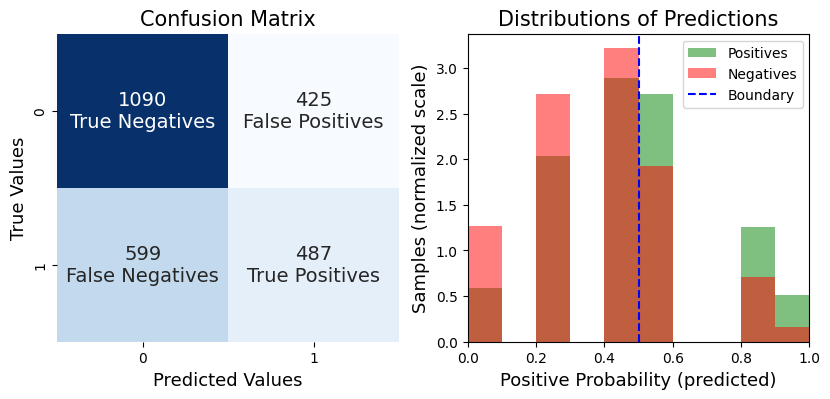

In [207]:
avalia_Classificacao(vizin,X_test, y_test, estimado)

## Árvore de decisão

In [208]:
# estamos criando um modelo e dizendo para o algoritmo identificar os 5 vizinhos mais próximos, contar a frequencia da variável resposta nas proximidades e eleger onde ficará aquele ponto
arvere = DecisionTreeClassifier(max_depth=5, criterion='entropy')

In [209]:
# vamos treinar o modelo na base de treino
arvere.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [210]:
# criando as previsões dando como entrada os valores da base de teste
arvere.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

In [211]:
# vamos atribuir a previsão num objeto chamado estimado
estimado_arvere = arvere.predict(X_test)

In [212]:
# vamos atribuir as probabilidades num objeto chamado probs
probs_arvere = arvere.predict_proba(X_test)

## Avaliando o modelo

### Acurácia

In [213]:
acc = accuracy_score(y_test, estimado_arvere)
print("accuracy_score: %.4f" % acc)

accuracy_score: 0.6098


### Precisao, Recall e F1 (por classe e ponderados)

In [214]:
print(classification_report(y_test, estimado_arvere))

              precision    recall  f1-score   support

           0       0.64      0.74      0.69      1515
           1       0.54      0.43      0.48      1086

    accuracy                           0.61      2601
   macro avg       0.59      0.58      0.58      2601
weighted avg       0.60      0.61      0.60      2601



### Matriz de confusão, distribuição de probabilidades e curva ROC

AttributeError: ignored

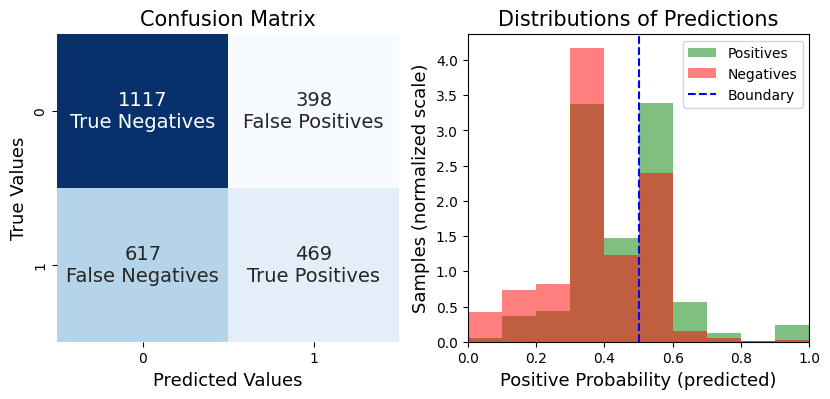

In [216]:
avalia_Classificacao(arvere,X_test, y_test, estimado_arvere)

## Regressão logística

In [217]:
# estamos criando um modelo e dizendo para o algoritmo identificar os 5 vizinhos mais próximos, contar a frequencia da variável resposta nas proximidades e eleger onde ficará aquele ponto
reglog = LogisticRegression()

In [218]:
# vamos treinar o modelo na base de treino
reglog.fit(X_train, y_train)

LogisticRegression()

In [219]:
# criando as previsões dando como entrada os valores da base de teste
reglog.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

In [220]:
# vamos atribuir a previsão num objeto chamado estimado
estimado_reglog = reglog.predict(X_test)

In [221]:
# vamos atribuir as probabilidades num objeto chamado probs
probs_reglog = reglog.predict_proba(X_test)

## Avaliando o modelo

### Acurácia

In [222]:
acc = accuracy_score(y_test, estimado_reglog)
print("accuracy_score: %.4f" % acc)

accuracy_score: 0.6275


### Precisao, Recall e F1 (por classe e ponderados)

In [223]:
print(classification_report(y_test, estimado_reglog))

              precision    recall  f1-score   support

           0       0.63      0.85      0.73      1515
           1       0.60      0.31      0.41      1086

    accuracy                           0.63      2601
   macro avg       0.62      0.58      0.57      2601
weighted avg       0.62      0.63      0.60      2601



### Matriz de confusão, distribuição de probabilidades e curva ROC

AttributeError: ignored

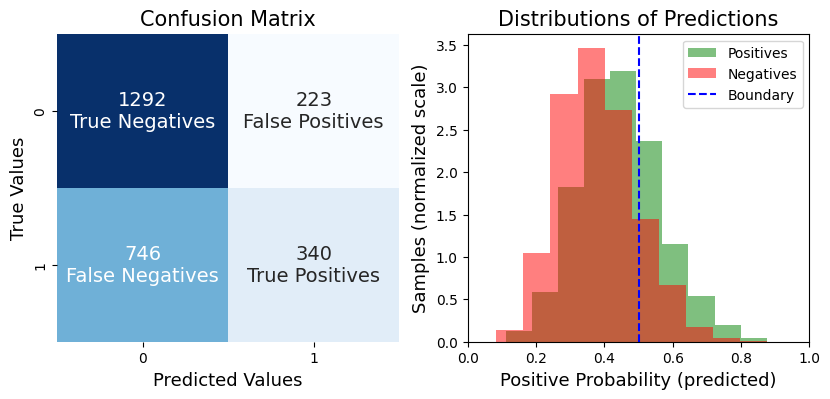

In [224]:
avalia_Classificacao(reglog,X_test, y_test, estimado_reglog)

Para obter os resultados atuais, dos três modelos de classificação, tive que fazer alguns processos em minha análise exploratória, tratei os dados outliers de algumas variáveis como listado lá em cima, fiz algumas análises de dispersão encontrando correlações onde também citei lá em cima, na qual me ajudou a criar novas variáveis para trazer aos modelos de classificação, onde conseguin melhorar os indicadores de avaliação.

Comparado aos modelos bases que foi disponibilizado,com o desafio de melhorar os indicadores de avaliação, obtive sucesso nos três modelos, que ficou da seguinte maneira:

**K vizinhos**

accuracy_score:

modelo_professor - 0.5559

modelo_diogo - 0.6063


---



Precisao, Recall e F1

modelo_professor - precision    recall  f1-score

           0       0.61      0.68      0.64      
           1       0.46      0.39      0.42




modelo_diogo -   precision    recall  f1-score  

           0       0.65      0.72      0.68     
           1       0.53      0.45      0.49



**Árvore de decisão**

accuracy_score:

modelo_professor - 0.6097

modelo_diogo - 0.6098



---



Precisao, Recall e F1

modelo_professor -  precision    recall  f1-score

           0       0.63      0.78      0.70
           1       0.55      0.37      0.44


modelo_diogo -  precision    recall  f1-score  

           0       0.64      0.74      0.69      
           1       0.54      0.43      0.48



**Regressão logística**

accuracy_score:

modelo_professor - 0.6205

modelo_diogo - 0.6275



---



Precisao, Recall e F1


modelo_professor - precision    recall  f1-score

           0       0.63      0.86      0.72     
           1       0.59      0.29      0.39


modelo_diogo -  precision    recall  f1-score

           0       0.63      0.85      0.73    
           1       0.60      0.31      0.41




---


Matriz de confusão, distribuição de probabilidades e curva ROC:

Infelizmente por conta do AttributeError: module 'sklearn.metrics' has no attribute 'plot_roc_curve, não aparece explicito as precisões, então a interpretação foi feita pela a imagem do gráfico mesmo, nos três modelos.

Como já veio com esse erro da biblioteca, até tentei pesquisar para achar a solução para que em baixo da imagem aparecesse a precision, recall, f1-score, porém não obtive sucesso, mas assim como foi feito em sala de aula, da para interpretar somente olhando o gráfico, como fiz.




# **Conclusão**

Gostaria de deixar aqui meu comentário da AC2, e também com a anterior AC1, independente da nota, estou muito contente com a curva de aprendizado, onde podemos ver quais os processos que relamente se tem no mercado de trabalho na aréa de ciência de dados, claro guardado as devidas proporções, mas é evidente que estamos tendo conteúdos que nos mostra como é a realidade.

Ainda mais eu que gosto muito de futebol, fazer um trabalho que se trata desse assunto, prever previsões, como fazemos em casas de apostas, é muito bacana, sempre tive curiosidade em saber como era feito essas análises preditivas, e como já disse antes, guardadas as devidas proporções, já da para ter uma noção do quão amplo é essá área de ciência de dados, e muito desafiador. Claro, gostaria de ter feito ainda melhor, de ter chegado em um resultado melhor, mas só de ter conseguido melhorar um pouco os indicadores de avaliação já fico satisfeito.

Entendo que daqui para frente, iremos adquirir ainda mais conhecimento para aperfeiçoarmos essa técnica para chegar em um resultado melhor.

Só gostaria de entender melhor os códigos da criação da função, e também enterder de forma mais técnica os comandos para criação dos três modelos, infelizemnte só tivermos uma aula para que se explicasse tudo, mas se der para nas proxímas aula focarmos também na lógica dos comandos seria de extrema importância, também irei estudar por fora para ter um melhor entendimento.

***OBRIGADO!***
